In [85]:
# tokenization 
#stemming 
#lemmatization


## Data Preparation

In [86]:
import pandas as pd 
import numpy as np 
import nltk
from nltk.stem.porter import PorterStemmer
stemmer=PorterStemmer()
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
import time
import random

[nltk_data] Downloading package punkt_tab to /home/puzan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [87]:
def tokenize(sentence):
    return nltk.word_tokenize(sentence)
    
def stem(word):
    " Stemmize the word"
    return stemmer.stem(word.lower())
def bag_of_words(tokenized_sentence,all_words):
    """Return bags of words"""
    tokenized_sentence=[stem(w) for w in tokenized_sentence]
    bag=np.zeros(len(all_words),dtype=np.float32)
    for idx,w in enumerate (all_words):
        if w in tokenized_sentence:
            bag[idx]=1.0
    return bag


In [88]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset,DataLoader

In [89]:
# training 
import json



In [90]:
with open('data.json','r') as f :
    intents=json.load(f)

In [91]:
all_words=[]
tags=[]
xy=[]
for i in intents['intents']:
    tag=i['tag']
    tags.append(tag)
    for pattern in i['patterns']:
        w=nltk.word_tokenize(pattern) #tokeinize the words
        all_words.extend(w)
        xy.append((w,tag))
remove_words=['!','?','.',',']
all_words=[stem(w) for w in all_words if w not in remove_words] #stem and remove the pucntuation
all_words=sorted(set(all_words)) #get unique 
tags=sorted(set(tags))

In [92]:
X_train=[]
y_train=[]
for (pattern_words,tag) in xy:
    bag=bag_of_words(pattern_words,all_words) #implementing bow
    X_train.append(bag)
    label=tags.index(tag)
    y_train.append(label)# Cross entropy

X_train=np.array(X_train)
y_train=np.array(y_train)


## Dataset and Dataloading

In [93]:
class Mydataset(Dataset):
    def __init__(self) -> None:
        self.n_samples = len(X_train)
        self.x_data=X_train
        self.y_data=y_train
    
    def __len__(self) -> int:
        return self.n_samples
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]

In [94]:
dataset=Mydataset()
batch_size=8
train_loader=DataLoader(dataset=dataset,batch_size=8,shuffle=True,num_workers=2)

In [95]:
# making pytorch model

## Model for training

In [96]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size,hidden_size,output_classes):
        super().__init__()
        self.l1=nn.Linear(input_size,hidden_size)
        self.l2=nn.Linear(hidden_size,hidden_size)
        self.l3=nn.Linear(hidden_size,output_classes)
        self.relu=nn.ReLU()
    
    def forward(self,x):
        out=self.l1(x)
        out=self.relu(out)
        out=self.l2(out)
        out=self.relu(out)
        out=self.l3(out)
        return out




In [97]:
num_epochs=200
input_size=len(X_train[0])
hidden_size=8
output_classes=len(tags)

In [98]:
model=NeuralNetwork(input_size=input_size,hidden_size=hidden_size,output_classes=output_classes)


In [99]:
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

## Model training on different optimizers

In [100]:

start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.to(device)
losses = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(200):
    for words, label in train_loader:
        words = words.to(device)
        label = label.to(device)

        # Forward pass
        output = model(words)
        loss = criterion(output, label)

        # Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # Update weights

        losses.append(loss.item())

    # Check for improvement
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping condition
    if epochs_no_improve == patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

end_time = time.time()
print(f"Final best loss: {best_loss:.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [1/10], Loss: 1.9588
No improvement for 1 epoch(s).
Epoch [2/10], Loss: 1.9839
No improvement for 2 epoch(s).
Epoch [3/10], Loss: 2.0681
Epoch [4/10], Loss: 1.8711
Epoch [5/10], Loss: 1.7515
Epoch [6/10], Loss: 1.6458
Epoch [7/10], Loss: 1.5326
Epoch [8/10], Loss: 1.4063
No improvement for 1 epoch(s).
Epoch [9/10], Loss: 1.7791
Epoch [10/10], Loss: 0.7747
No improvement for 1 epoch(s).
Epoch [11/10], Loss: 1.7446
No improvement for 2 epoch(s).
Epoch [12/10], Loss: 1.7069
No improvement for 3 epoch(s).
Early stopping triggered at epoch 13.
Final best loss: 0.77469
Total training time: 1.50 seconds


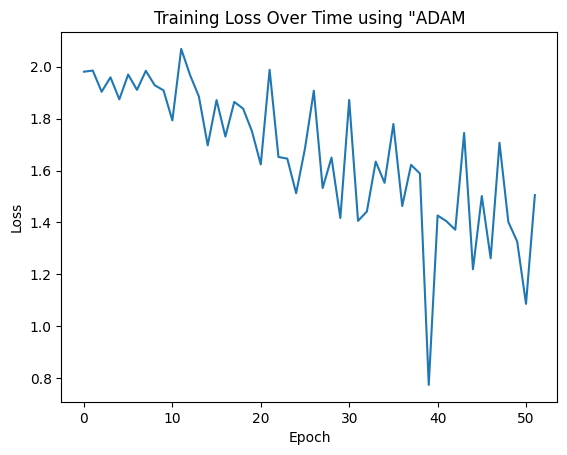

In [101]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "ADAM')
plt.show()

In [102]:
#using stochastic gradient descent

In [103]:

start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model.to(device)
losses = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(200):
    for words, label in train_loader:
        words = words.to(device)
        label = label.to(device)

        # Forward pass
        output = model(words)
        loss = criterion(output, label)

        # Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # Update weights

        losses.append(loss.item())

    # Check for improvement
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping condition
    if epochs_no_improve == patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

end_time = time.time()
print(f"Final best loss: {best_loss:.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [1/10], Loss: 1.1648
No improvement for 1 epoch(s).
Epoch [2/10], Loss: 1.3499
No improvement for 2 epoch(s).
Epoch [3/10], Loss: 1.2110
Epoch [4/10], Loss: 0.8970
No improvement for 1 epoch(s).
Epoch [5/10], Loss: 1.6632
Epoch [6/10], Loss: 0.3874
No improvement for 1 epoch(s).
Epoch [7/10], Loss: 1.1427
No improvement for 2 epoch(s).
Epoch [8/10], Loss: 1.3364
No improvement for 3 epoch(s).
Early stopping triggered at epoch 9.
Final best loss: 0.38737
Total training time: 1.12 seconds


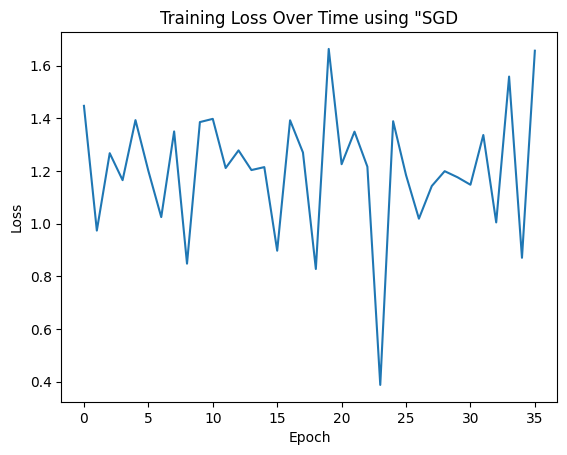

In [104]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "SGD')
plt.show()

In [105]:

start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01) 

model.to(device)
losses = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(200):
    for words, label in train_loader:
        words = words.to(device)
        label = label.to(device)

        # Forward pass
        output = model(words)
        loss = criterion(output, label)

        # Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # Update weights

        losses.append(loss.item())

    # Check for improvement
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping condition
    if epochs_no_improve == patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

end_time = time.time()
print(f"Final best loss: {best_loss:.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [1/10], Loss: 1.0060
Epoch [2/10], Loss: 0.3952
Epoch [3/10], Loss: 0.2770
No improvement for 1 epoch(s).
Epoch [4/10], Loss: 0.9602
Epoch [5/10], Loss: 0.1162
No improvement for 1 epoch(s).
Epoch [6/10], Loss: 0.6465
Epoch [7/10], Loss: 0.0275
No improvement for 1 epoch(s).
Epoch [8/10], Loss: 1.1042
Epoch [9/10], Loss: 0.0232
No improvement for 1 epoch(s).
Epoch [10/10], Loss: 0.0306
Epoch [11/10], Loss: 0.0082
No improvement for 1 epoch(s).
Epoch [12/10], Loss: 0.0431
No improvement for 2 epoch(s).
Epoch [13/10], Loss: 0.0615
No improvement for 3 epoch(s).
Early stopping triggered at epoch 14.
Final best loss: 0.00815
Total training time: 1.66 seconds


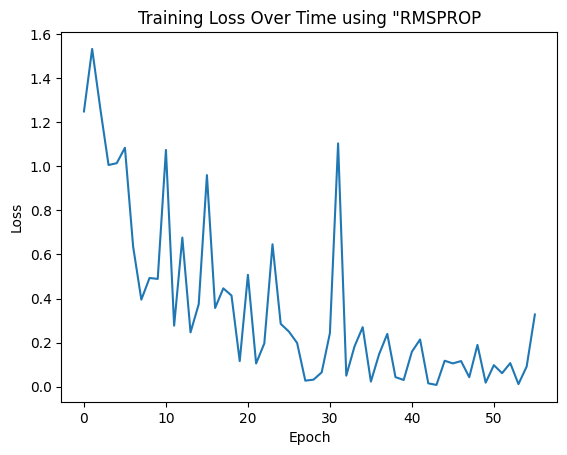

In [106]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "RMSPROP')
plt.show()

In [107]:

start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

model.to(device)
losses = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(200):
    for words, label in train_loader:
        words = words.to(device)
        label = label.to(device)

        # Forward pass
        output = model(words)
        loss = criterion(output, label)

        # Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # Update weights

        losses.append(loss.item())

    # Check for improvement
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping condition
    if epochs_no_improve == patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

end_time = time.time()
print(f"Final best loss: {best_loss:.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [1/10], Loss: 0.2674
Epoch [2/10], Loss: 0.0023
No improvement for 1 epoch(s).
Epoch [3/10], Loss: 0.0147
No improvement for 2 epoch(s).
Epoch [4/10], Loss: 0.2418
No improvement for 3 epoch(s).
Early stopping triggered at epoch 5.
Final best loss: 0.00234
Total training time: 0.54 seconds


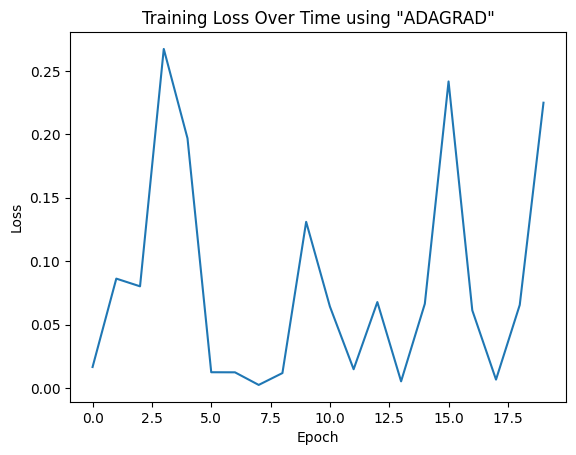

In [108]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "ADAGRAD"')
plt.show()

## Model Evaluation

In [109]:
data={
    "model_state":model.state_dict(),
    "input_size":input_size,
    "hidden_size":hidden_size,
    "all_words":all_words,
    "tags":tags
}
FILE_PATH="data.pth"
torch.save(data,FILE_PATH)

In [110]:
with open('data.json', 'r') as f:
    intents=json.load(f)
data=torch.load(FILE_PATH)
model=NeuralNetwork(input_size,hidden_size,output_classes)
model_state=data['model_state']
model.load_state_dict(model_state)
model.eval()


/tmp/ipykernel_219134/4220059822.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data=torch.load(FILE_PATH)


NeuralNetwork(
  (l1): Linear(in_features=54, out_features=8, bias=True)
  (l2): Linear(in_features=8, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=7, bias=True)
  (relu): ReLU()
)

In [111]:
# name="Helper"
# print(" Want help : type 'q' to exit ")
# while True:
#     sentence=input("User:")
#     if sentence=="q":
#         break
#     sentence=tokenize(sentence)
#     X=bag_of_words(sentence,all_words)
#     x=X.reshape(1,X.shape[0])
#     x=torch.from_numpy(x)
#     output=model(x)
#     _,predicted=torch.max(output,dim=1)
#     tag=tags[predicted.item()]
#     probs=torch.softmax(output,dim=1)
#     prob=probs[0][predicted.item()]
#     print(prob)
#     if prob.item()>0.75:
#         for intent in intents['intents']:
#             if tag == intent['tag']:
#                 print(f"{name}:{random.choice[intent['responses']]}")
#     else:
#         print(f"{name}: I didnot understand")




